# Comparison of the dynamical exponent of MCMC and Wolff algorithms

After these preparations, we are ready to demonstrate the usefulness of the Wolff algorithm: unlike the single site algorithm, which suffers from critical slowing down at the critical temperature, this algorithm can still produce fairly uncorrelated measurements. We derive the dynamical exponents for the 2D and 3D Ising model.

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
from ising_common_procedures import *
from scipy.stats import linregress,t
from tqdm import tqdm
from tqdm import trange

plot_colors=['tab:blue','tab:orange','tab:green','tab:red']

In [2]:
def acorr(j,beta,L,warm,meas):
    arr=init_grid((L,L))
    wolff_step(arr,beta,j,warm)
    acc=np.zeros((1,L))
    for i in trange(0,meas):
        wolff_step(arr,beta,j,1)
        if arr[0,0]>0:
            acc+=arr[:,0]
        else:
            acc-=arr[:,0]
    return np.array(acc[0,:]/meas)

In [7]:
L=140
num_warmup=6000
num_meas=20000
j=1
spin_autocorr=acorr(j,beta_c,L,num_warmup,num_meas)

100%|██████████| 20000/20000 [00:17<00:00, 1133.54it/s]


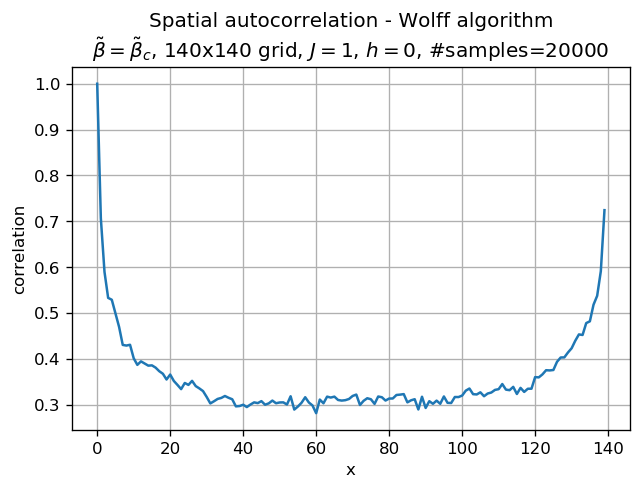

In [9]:
fig_wolff_acorr, ax=plt.subplots(1,1,dpi=120)
ax.plot(spin_autocorr)
ax.set_title(f'Spatial autocorrelation - Wolff algorithm\n'+r'$\tilde\beta=\tilde\beta_c$'+f', {L}x{L} grid, $J={j}$, $h=0$, #samples={num_meas}')
ax.set_xlabel(r'x')
ax.set_ylabel(r'correlation')
ax.grid()
fig_wolff_acorr.savefig('images/critical-wolff-spatial.png')

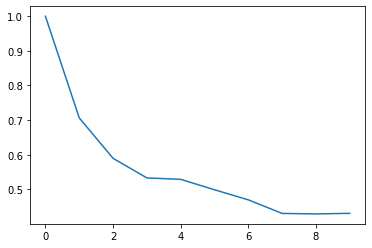

In [10]:
plt.plot(spin_autocorr[:10])

In [11]:
xi=-1/linregress(range(10),\
            np.log(spin_autocorr[:10])).slope
xi

12.61050838203258

This is not even close to 140, and it should be infinite. Not a good measure.

## Finite size scaling for Wolff algorithm

In [60]:
def Gamma(array,t):
    t=abs(t)
    avg=np.average(array)
    s=0
    for i in range(len(array)-t):
        s+=(array[i]-avg)*(array[i+t]-avg)
    s/=(len(array)-t)
    return s

# returns the normalized autocorrelation function for all
# indices in ´values´
def GammaNormalized(array,values):
    gamma0 = Gamma(array,0)
    return [Gamma(array,t)/gamma0 for t in values]

def extract_exponent_wolff(results,cluster_results):
    return linregress(np.log(list(results)),\
            np.log([-1/linregress(range(4),np.log(results[n][:4])).slope*(cluster_results[n]/n/n) for n in results])).slope

def extract_exponent_metropolis(results):
    return linregress(np.log(list(results)),\
            np.log([-1/linregress(range(4),np.log(results[n][:4])).slope for n in results])).slope

def meas_error(data):
    num_samples=len(data)
    return np.sqrt(np.var(data)/(num_samples-1))*t.ppf(0.975, num_samples-1)

In [64]:
e_acorr={}
m_acorr={}
c_avg={}
# constants
num_warmup=6000
num_meas=100000
j=1
beta=beta_c
# output array for magnetic moment and energy
cluster_result=np.zeros(num_meas)
m_result=np.zeros(num_meas)
e_result=np.zeros(num_meas)
for n in tqdm([5,10,15,20,25,30,35,40]):
    arr=init_grid((n,n))
    wolff_step(arr,beta,j,num_warmup)
    wolff_measurement_full(arr, beta, j, cluster_result, m_result,e_result)
    m_acorr[n]=GammaNormalized(m_result,range(10))
    e_acorr[n]=GammaNormalized(e_result,range(10))
    c_avg[n]=np.average(cluster_result)

100%|██████████| 8/8 [00:49<00:00,  6.22s/it]


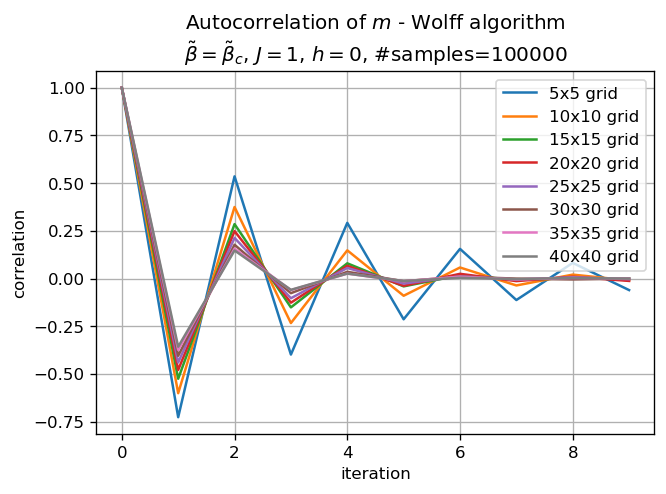

In [65]:
fig_acorr_wolff_m, ax=plt.subplots(1,1,dpi=120)
for n,val in m_acorr.items():
    ax.plot(val,label=f'{n}x{n} grid')
ax.set_title(f'Autocorrelation of $m$ - Wolff algorithm\n'+r'$\tilde\beta=\tilde\beta_c$'+f', $J={j}$, $h=0$, #samples={num_meas}')
ax.legend()
ax.set_xlabel(r'iteration')
ax.set_ylabel(r'correlation')
ax.grid()
fig_acorr_wolff_m.savefig('images/critical-wolff-m.png')

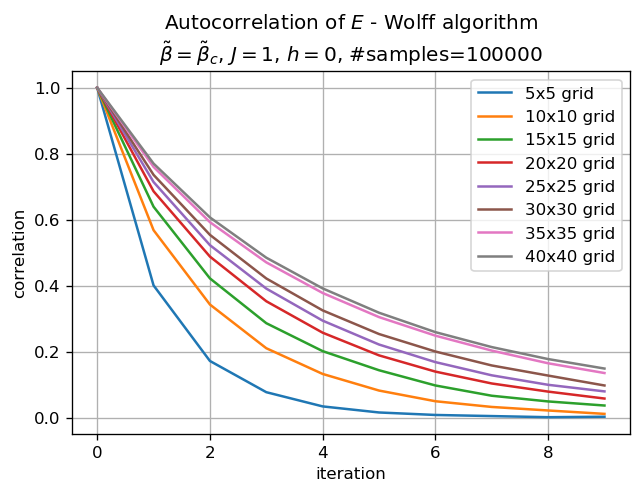

In [66]:
fig_acorr_wolff_e, ax=plt.subplots(1,1,dpi=120)
for n,val in e_acorr.items():
    ax.plot(np.abs(val),label=f'{n}x{n} grid')
ax.set_title(f'Autocorrelation of $E$ - Wolff algorithm\n'+r'$\tilde\beta=\tilde\beta_c$'+f', $J={j}$, $h=0$, #samples={num_meas}')
ax.legend()
ax.set_xlabel(r'iteration')
ax.set_ylabel(r'correlation')
ax.grid()
fig_acorr_wolff_e.savefig('images/critical-wolff-e.png')

In [67]:
extract_exponent_wolff({n:np.abs(data) for n,data in m_acorr.items()},c_avg)

-0.7838503718752232

In [68]:
extract_exponent_wolff(e_acorr,c_avg)

0.3542627526834759

In [70]:
# constants
num_warmup=6000
num_meas=100000
j=1
beta=beta_c
# output array for magnetic moment and energy
cluster_result=np.zeros(num_meas)
m_result=np.zeros(num_meas)
e_result=np.zeros(num_meas)
e_exponent_w=[]
m_exponent_w=[]
for i in range(10):
    e_acorr={}
    m_acorr={}
    c_avg={}
    for n in tqdm([5,10,15,20,25,30,35,40]):
        arr=init_grid((n,n))
        wolff_step(arr,beta,j,num_warmup)
        wolff_measurement_full(arr, beta, j, cluster_result, m_result,e_result)
        m_acorr[n]=GammaNormalized(m_result,range(10))
        e_acorr[n]=GammaNormalized(e_result,range(10))
        c_avg[n]=np.average(cluster_result)
    m_acorr_abs={n:np.abs(data) for n,data in m_acorr.items()}
    print(f'm: {extract_exponent_wolff(m_acorr_abs,c_avg)}')
    print(f'e: {extract_exponent_wolff(e_acorr,c_avg)}')
    m_exponent_w+=[extract_exponent_wolff(m_acorr_abs,c_avg)]
    e_exponent_w+=[extract_exponent_wolff(e_acorr,c_avg)]

  0%|          | 0/8 [00:00<?, ?it/s]

m: -0.7751125562816883
e: 0.3397591019559836


  0%|          | 0/8 [00:00<?, ?it/s]

m: -0.7644389752823013
e: 0.33252012801848535


  0%|          | 0/8 [00:00<?, ?it/s]

m: -0.7586726611343055
e: 0.33525112330193635


  0%|          | 0/8 [00:00<?, ?it/s]

m: -0.7732231401741245
e: 0.33419076968574124


  0%|          | 0/8 [00:00<?, ?it/s]

m: -0.7663536051386443
e: 0.3534562645318946


  0%|          | 0/8 [00:00<?, ?it/s]

m: -0.7701070254252783
e: 0.3530396433693725


  0%|          | 0/8 [00:00<?, ?it/s]

m: -0.779447595340293
e: 0.34250181124662776


  0%|          | 0/8 [00:00<?, ?it/s]

m: -0.7780666739890643
e: 0.3403635583713879


  0%|          | 0/8 [00:00<?, ?it/s]

m: -0.7801516240445548
e: 0.3360435663035439


100%|██████████| 8/8 [00:49<00:00,  6.20s/it]

m: -0.7711708809731205
e: 0.3207929986007864


In [71]:
print(f'm exponent: {np.average(m_exponent_w)} +- {meas_error(m_exponent_w)}')
print(f'E exponent: {np.average(e_exponent_w)} +- {meas_error(e_exponent_w)}')

m exponent: -0.7716744737783375 +- 0.00500059101683318
E exponent: 0.33879189653857594 +- 0.006910046647103575


## Finite size scaling for Metropolis algorithm

In [48]:
m_acorr_metr={}
e_acorr_metr={}
# constants
num_warmup=10000
num_meas=100000
j=1
beta=beta_c
# output array for magnetic moment and energy
m_result=np.zeros(num_meas)
e_result=np.zeros(num_meas)
for n in tqdm([5,10,15,20,25,30,35]):
    arr=init_grid((n,n))
    metropolis_hastings_sweep(arr,beta,j,num_warmup)
    metropolis_hastings_measurement(arr, beta, j, m_result,e_result)
    m_acorr_metr[n]=GammaNormalized(m_result,range(10))
    e_acorr_metr[n]=GammaNormalized(e_result,range(10))

100%|██████████| 7/7 [00:47<00:00,  6.72s/it]


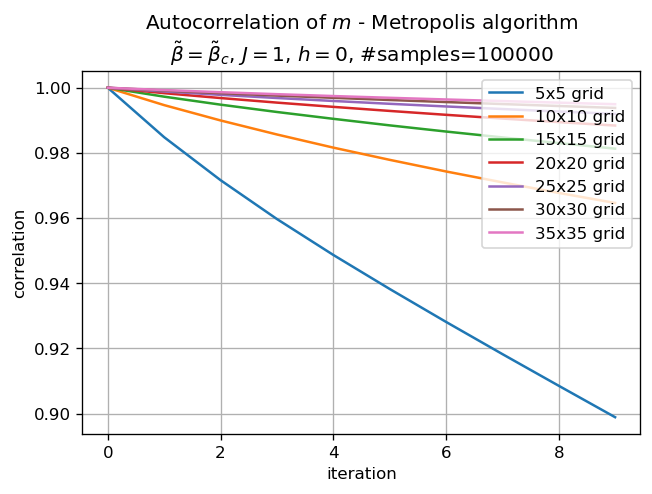

In [49]:
fig_acorr_metropolis_m, ax=plt.subplots(1,1,dpi=120)
for n,val in m_acorr_metr.items():
    ax.plot(val,label=f'{n}x{n} grid')
ax.set_title(f'Autocorrelation of $m$ - Metropolis algorithm\n'+r'$\tilde\beta=\tilde\beta_c$'+f', $J={j}$, $h=0$, #samples={num_meas}')
ax.legend(loc='upper right')
ax.set_xlabel(r'iteration')
ax.set_ylabel(r'correlation')
ax.grid()
fig_acorr_metropolis_m.savefig('images/critical-metropolis-m.png')

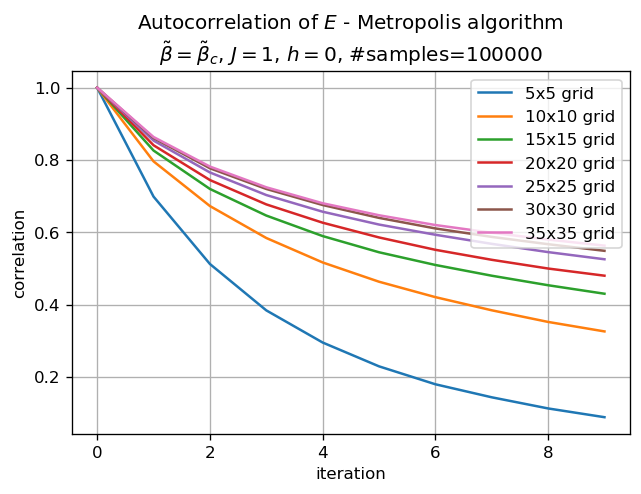

In [50]:
fig_acorr_metropolis_e, ax=plt.subplots(1,1,dpi=120)
for n,val in e_acorr_metr.items():
    ax.plot(val,label=f'{n}x{n} grid')
ax.set_title(f'Autocorrelation of $E$ - Metropolis algorithm\n'+r'$\tilde\beta=\tilde\beta_c$'+f', $J={j}$, $h=0$, #samples={num_meas}')
ax.legend(loc='upper right')
ax.set_xlabel(r'iteration')
ax.set_ylabel(r'correlation')
ax.grid()
fig_acorr_metropolis_e.savefig('images/critical-metropolis-e.png')

In [51]:
extract_exponent_metropolis(m_acorr_metr)

1.5846821229385364

In [52]:
extract_exponent_metropolis(e_acorr_metr)

0.553812094163284

In [54]:
# constants
num_warmup=10000
num_meas=100000
j=1
beta=beta_c
# output array for magnetic moment and energy
m_result=np.zeros(num_meas)
e_result=np.zeros(num_meas)
e_exponent=[]
m_exponent=[]
for i in range(10):
    m_acorr_metr={}
    e_acorr_metr={}
    for n in tqdm([5,10,15,20,25,30,35]):
        arr=init_grid((n,n))
        metropolis_hastings_sweep(arr,beta,j,num_warmup)
        metropolis_hastings_measurement(arr, beta, j, m_result,e_result)
        m_acorr_metr[n]=GammaNormalized(m_result,range(10))
        e_acorr_metr[n]=GammaNormalized(e_result,range(10))
    print(f'm: {extract_exponent_metropolis(m_acorr_metr)}')
    print(f'e: {extract_exponent_metropolis(e_acorr_metr)}')
    m_exponent+=[extract_exponent_metropolis(m_acorr_metr)]
    e_exponent+=[extract_exponent_metropolis(e_acorr_metr)]

  0%|          | 0/7 [00:00<?, ?it/s]

m: 1.610316389306566
e: 0.5396753232726651


  0%|          | 0/7 [00:00<?, ?it/s]

m: 1.6218590975999527
e: 0.5535808348665217


  0%|          | 0/7 [00:00<?, ?it/s]

m: 1.5906552644732532
e: 0.5781625703300665


  0%|          | 0/7 [00:00<?, ?it/s]

m: 1.4805647635253238
e: 0.5466449929306931


  0%|          | 0/7 [00:00<?, ?it/s]

m: 1.484064523945399
e: 0.5667443485350804


  0%|          | 0/7 [00:00<?, ?it/s]

m: 1.6156224361637455
e: 0.5351498974594127


  0%|          | 0/7 [00:00<?, ?it/s]

m: 1.633515888927527
e: 0.5375645739833451


  0%|          | 0/7 [00:00<?, ?it/s]

m: 1.4636171722186204
e: 0.531714445937069


  0%|          | 0/7 [00:00<?, ?it/s]

m: 1.6170498215538742
e: 0.5568003511867677


100%|██████████| 7/7 [00:46<00:00,  6.64s/it]

m: 1.6119901896343478
e: 0.5534920866383278


In [63]:
print(f'm exponent: {np.average(m_exponent)} +- {meas_error(m_exponent)}')
print(f'E exponent: {np.average(e_exponent)} +- {meas_error(e_exponent)}')

m exponent: 1.5729255547348608 +- 0.048546709462300504
E exponent: 0.5499529425139948 +- 0.01058933659252804


## Susceptibility scaling for the Wolff algorithm

In [45]:
def cumulative_est_var(data):
    mean = data[0]
    M2 = 0
    result = np.zeros(data.shape)
    for count in range(1,data.size):
        delta = data[count] - mean
        mean += delta / (count + 1)
        delta2 = data[count] - mean
        M2 += delta * delta2
        result[count] = M2 / count
    return result

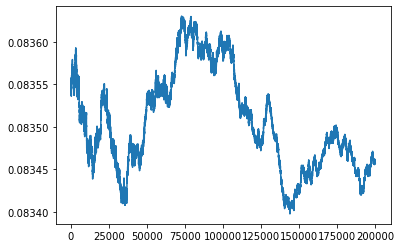

In [235]:
plt.plot(cumulative_est_var(np.random.random(300000))[100000:])

In [83]:
m_acorr={}
# constants
num_warmup=6000
num_meas=100000
j=1
beta=0.4406
# output array for magnetic moment and energy
cluster_result=np.zeros(num_meas)
m_result=np.zeros(num_meas)
e_result=np.zeros(num_meas)
for n in tqdm([30,40,50,60,70]):
    arr=init_grid((n,n))
    wolff_step(arr,beta,j,num_warmup)
    wolff_measurement_full(arr, beta, j, cluster_result, m_result,e_result)
    m_acorr[n]=GammaNormalized(cumulative_est_var(m_result)[num_meas//2:],range(10))

100%|██████████| 5/5 [01:21<00:00, 16.22s/it]


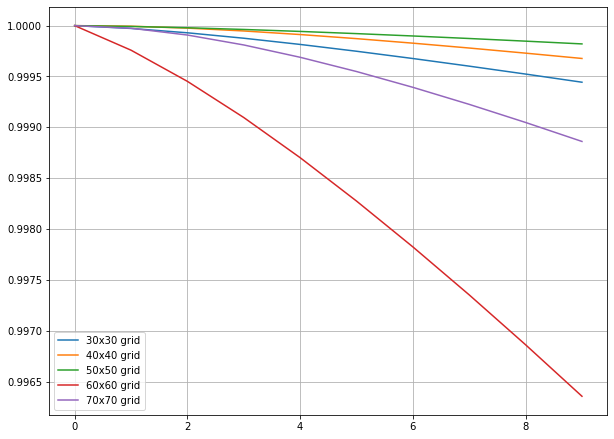

In [84]:
fig, ax=plt.subplots(1,1, figsize=(10,7.5))
for n,val in sorted(m_acorr.items()):
    ax.plot(val,label=f'{n}x{n} grid')
ax.legend()
ax.grid()

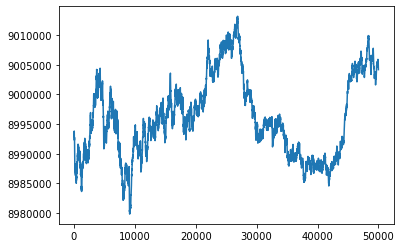

In [85]:
plt.plot(cumulative_est_var(m_result)[num_meas//2:])